In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from tqdm import tqdm, trange
from numba import njit, objmode

In [2]:
#data_combine = pd.read_hdf('/depot/darkmatter/data/jupyterhub/Amanda/Triggerless_minitrees/180706_1451_lonehit_combined_Aug2020.h5')

data_combine = pd.read_hdf('/depot/darkmatter/data/jupyterhub/Amanda/Triggerless_minitrees/180706_1451_lonehit_combined_Nov2022.h5')

In [3]:
min_primary_size_PE = 1000 #min size of primary peaks (PE)
overlap_cut_time_s = 3e-1 #the time constant for exponential overlap cut, https://xe1t-wiki.lngs.infn.it/doku.php?id=xenon:xenon1t:adepoian:overlapcut_overview
overlap_cut_ratio = 0.1 #peaks are only accepted if all previous primary peaks multiplied by (t/drift_time)^(overlap_cut_power) is less than overlap_cut_ratio of the current peak
overlap_cut_max_times = 30 #number of time constants to consider previous peaks for overlap cut
max_drift_time_s = 2.5e-3 #s
edge_time_discard_s = 1 #s, discard the first and last few seconds of data because it is unknown if there's overlap from earlier, and the last few peaks won't have proper trains.
SE_gain = 31 #https://xe1t-wiki.lngs.infn.it/doku.php?id=xenon:abby:segain_evolution

In [4]:
# limiting the data to the time of lonehits
data_lh = data_combine[data_combine['type_digit']==0]
data = data_combine[data_combine['gcenter_time'] < max(data_lh['gcenter_time'])]
data = data[data['gcenter_time'] > min(data_lh['gcenter_time'])]

In [5]:
df_prim = data_combine.drop_duplicates(['gcenter_time_primary'])
df_prim = df_prim.sort_values('gcenter_time')
df_prim = df_prim.reset_index(drop=True)


In [6]:
### These functions were developed by Juehang Qin

@njit
def shadow_area(area, delta_times, overlap_cut_time_s):
    """
    Calculates the shadow area of an object with given area and time delay.

    Parameters:
    area (float): The area of the current peak.
    delta_times (float): The time delay between the current peak and subsequent peaks.
    overlap_cut_time_s (float, optional): The overlap cut time constant in seconds. Default is `overlap_cut_time_s`.

    Returns:
    float: The shadow area of the object.

    """
    return area * np.exp(-delta_times / overlap_cut_time_s)

@njit
def window_loop_func(time_diff_ns, overlap_cut_time_s, overlap_cut_max_times, last_index, current_time, N, primary_times_int):
    """
    This function takes in several parameters including the time difference in nanoseconds, 
    the overlap cut time in seconds, the maximum allowed overlaps, the last index, the current time,
    and the total number of elements. It then iterates through a while loop, incrementing the last index
    and updating the time difference until the time difference exceeds the limit set by the overlap cut time 
    multiplied by the maximum allowed overlaps or the last index becomes greater than or equal to N-2.
    The function returns the updated last index and time difference.
    """
    while time_diff_ns * 1e-9 < overlap_cut_time_s * overlap_cut_max_times and last_index < N-2:
        last_index += 1
        time_diff_ns = primary_times_int[last_index] - current_time
    return last_index, time_diff_ns


def peaks_to_reject(primary_areas, primary_times_int, overlap_cut_time_s, overlap_cut_max_times, overlap_cut_ratio):
    """
    Reject peaks that overlap with other peaks based on their areas.
    
    Args:
        primary_areas (numpy.ndarray): 1D array of peak areas.
        primary_times_int (numpy.ndarray): 1D array of corresponding peak times in nanoseconds.
        overlap_cut_time_s (float): Time constant for exponential overlap cut. Default is `overlap_cut_time_s`.
        overlap_cut_max_times (int): Number of overlap cut time constants to look for. Default is `overlap_cut_max_times`.
        overlap_cut_ratio (float): Ratio of shadow area to primary area that determines if a peak should be rejected. Default is `overlap_cut_ratio`.
    
    Returns:
        numpy.ndarray: 1D array of peak times in nanoseconds that are rejected.
    """
    N = len(primary_areas)
    shadow_areas_arr = np.zeros_like(primary_areas)
    for i in trange(0, N-1):
        current_area = primary_areas[i]
        current_time = primary_times_int[i]
        last_index = i+1
        time_diff_ns = primary_times_int[last_index] - current_time
        
        last_index, time_diff_ns = window_loop_func(time_diff_ns, overlap_cut_time_s, overlap_cut_max_times, last_index, current_time, N, primary_times_int)
        
        shadow_areas_arr[i+1: last_index+1] += shadow_area(current_area, (primary_times_int[i+1: last_index+1] - current_time)*1e-9, overlap_cut_time_s=overlap_cut_time_s)
    rejection_bool = primary_areas*overlap_cut_ratio < shadow_areas_arr
    return np.array(primary_times_int[rejection_bool])

def get_windows(primaries, selected_peaks, overlap_cut_time_s, overlap_cut_max_times, overlap_cut_ratio):
    """
    Computes the window lengths for a set of selected primary peaks.

    Parameters:
    -----------
    primaries: pandas.DataFrame
        A DataFrame containing all primary peaks.
    selected_peaks: pandas.DataFrame
        A DataFrame containing the selected primary peaks.
    overlap_cut_time_s: float, optional (default: overlap_cut_time_s)
        The maximum time overlap between two peaks, in seconds.
    overlap_cut_max_times: int, optional (default: overlap_cut_max_times)
        The maximum number of overlaps allowed between two peaks.

    Returns:
    --------
    window_lengths: list of floats
        A list of window lengths (in seconds) for each peak in selected_peaks.
    """
    window_lengths = []
    N = len(selected_peaks)
    for row in tqdm(selected_peaks.iterrows(), total=N):
        current_time = row[1]['gcenter_time_primary']
        current_area = row[1]['area_primary']
        primaries_in_shadow = primaries.query('gcenter_time_primary > @current_time and gcenter_time_primary < @current_time + @overlap_cut_time_s*@overlap_cut_max_times*1e9')
        delta_times_ns = primaries_in_shadow['gcenter_time_primary'].values - current_time
        shadow_areas = shadow_area(current_area, delta_times_ns*1e-9, overlap_cut_time_s=overlap_cut_time_s)
        window_end_bool = shadow_areas*overlap_cut_ratio < primaries_in_shadow['area_primary'].values
        peaks_outside_window = delta_times_ns[window_end_bool]
        if len(peaks_outside_window):
            window_lengths.append(np.min(peaks_outside_window)*1e-9)
        else:
            window_lengths.append(0)
    return window_lengths

@njit
def lone_hit_window_loop_func(data_lone_hits_times, start_time_loop, N_lh, end_time_loop, start_index, end_index):
    while data_lone_hits_times[start_index] < start_time_loop and start_index<N_lh-1000:
        start_index += 1000
    start_index -= 1000
    while data_lone_hits_times[end_index] < end_time_loop and start_index<N_lh-1000:
        end_index += 1000
    return start_index, end_index

def get_lone_hit_times(selected_peaks, window_lengths, data_lone_hits):
    """
    Extracts the lone hit times, time differences and primary areas for a given set
    of selected peaks and associated window lengths.

    Args:
    - selected_peaks (pandas.DataFrame): a DataFrame with peak information, including
        the 'time' and 'area' columns.
    - window_lengths (list-like): a list or array of window lengths, in seconds,
        associated with each peak.
    - data_lone_hits (pandas.DataFrame): a DataFrame with lone hit information, 
        including the 'time' column.

    Returns:
    - tuple: a tuple of three arrays, containing the lone hit times (in seconds), 
        the time differences with respect to the start of each peak window (in seconds),
        and the primary areas associated with each peak. 

    This function works by iterating over the selected peaks and their associated
    windows, finding all lone hits that fall within each window and extracting their 
    times, time differences and primary areas. The output is returned as a tuple of 
    arrays, with one entry per lone hit found across all windows.
    """
    i = 0
    lone_hit_times = []
    lone_hit_dts = []
    lone_hit_channel = []
    lone_hit_primary_areas = []
    lone_hit_primary_times = []
    lone_hit_primary_x = []
    lone_hit_primary_y = []
    N_lh = len(data_lone_hits)
    data_lone_hits_times = data_lone_hits['gcenter_time'].values
    for row in tqdm(selected_peaks.iterrows(), total=len(selected_peaks)):
        start_time_loop = row[1]['gcenter_time_primary']
        end_time_loop = row[1]['gcenter_time_primary'] + window_lengths[i]*1e9
        start_index = 0
        end_index = 0
        start_index, end_index = lone_hit_window_loop_func(data_lone_hits_times, start_time_loop, N_lh, end_time_loop, start_index, end_index)
        this_loop_lonehits = data_lone_hits.iloc[start_index:end_index].query('gcenter_time < @end_time_loop and gcenter_time > @start_time_loop')
        lone_hit_times.extend(this_loop_lonehits['gcenter_time'].values)
        lone_hit_dts.extend(this_loop_lonehits['gcenter_time'].values - start_time_loop)
        lone_hit_channel.extend(this_loop_lonehits['lone_hit_channel'].values)                
        lone_hit_primary_areas.extend([row[1]['area_primary']]*len(this_loop_lonehits))
        lone_hit_primary_times.extend([start_time_loop]*len(this_loop_lonehits))
        lone_hit_primary_x.extend([row[1]['x_primary']]*len(this_loop_lonehits))
        lone_hit_primary_y.extend([row[1]['y_primary']]*len(this_loop_lonehits))
        i+=1
    return lone_hit_times, lone_hit_dts, lone_hit_primary_areas, lone_hit_primary_x, lone_hit_primary_y,lone_hit_primary_times,lone_hit_channel

@njit
def histogram_with_weights_innerloop(unique_weights, weights_in_bin):
    poisson_numbers = []
    for unique_weight in unique_weights:
        poisson_numbers.append(np.sum(weights_in_bin == unique_weight))
    return poisson_numbers

def histogram_with_weights(items, weights, bins):
    """
    Computes a weighted histogram of a set of items with estimated Gaussian errorbars, using a given set of bin edges.

    Args:
    - items (list-like): a list or array of numerical values to be binned.
    - weights (list-like): a list or array of non-negative weights associated with each item.
    - bins (list-like): a list or array of bin edges (in seconds), defining the boundaries
        of each histogram bin.

    Returns:
    - tuple: a tuple of two arrays, containing the weighted histogram and the corresponding
        errors for each bin.

    This function works by first computing the bin number for each item, based on its value
    and the bin edges provided. It then groups the items and their corresponding weights by 
    bin number, and computes a Poisson error estimate for each unique weight value in each bin,
    using the number of occurrences of that value. Finally, it normalizes the sum of weights 
    within each bin by the width of the bin, and returns the resulting weighted histogram
    and error estimates as separate arrays.

    Note that the input items and the output histogram are assumed to be in units of seconds,
    while the input weights are unitless. The function uses numpy arrays and operations for 
    efficient computation and vectorization.
    """

    N = len(bins) - 1
    bin_widths = np.diff(bins)
    bin_numbers = np.searchsorted(bins, np.array(items)*1e-9, side='right')-1
    weighted_histogram = []
    errors = []
    for i in trange(0, N):
        items_in_bin = items[bin_numbers == i]
        weights_in_bin = weights[bin_numbers == i]
        unique_weights = np.unique(weights_in_bin)
        poisson_numbers = histogram_with_weights_innerloop(unique_weights, weights_in_bin)
        error = np.sqrt(np.sum(poisson_numbers*unique_weights**2))
        summed_weights = np.sum(weights_in_bin)
        weighted_histogram.append(summed_weights)
        errors.append(error)
    return np.array(weighted_histogram)/bin_widths, np.array(errors)/bin_widths

In [7]:
df_prim.keys()

Index(['area', 'area_fraction_top_primary', 'area_primary', 'area_sum_primary',
       'center_time', 'dt_primary', 'event_number', 'gcenter_time',
       'gcenter_time_primary', 'largest_hit_channel_primary',
       'lone_hit_channel', 'run_number', 'type_digit', 'wr_avg_primary',
       'x_primary', 'y_primary', 'carea_primary', 'goodness_of_fit_primary'],
      dtype='object')

In [8]:
primaries_for_overlap_cut = df_prim[df_prim['area_primary']>100]
rejected_peak_times = peaks_to_reject(primaries_for_overlap_cut['area_primary'].values, primaries_for_overlap_cut['gcenter_time_primary'].values, overlap_cut_time_s=overlap_cut_time_s, overlap_cut_max_times=overlap_cut_max_times, overlap_cut_ratio=overlap_cut_ratio)


100%|██████████| 107120/107120 [00:03<00:00, 27844.92it/s]


In [9]:
del primaries_for_overlap_cut

In [10]:
selected_peaks = df_prim.query('gcenter_time_primary not in @rejected_peak_times and area_primary>@min_primary_size_PE')
selected_peaks['window_lengths'] = get_windows(df_prim, selected_peaks, overlap_cut_time_s=overlap_cut_time_s, overlap_cut_max_times=overlap_cut_max_times, overlap_cut_ratio=overlap_cut_ratio)


100%|██████████| 1188/1188 [00:02<00:00, 431.93it/s]
/tmp/ipykernel_545642/203377941.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_peaks['window_lengths'] = get_windows(df_prim, selected_peaks, overlap_cut_time_s=overlap_cut_time_s, overlap_cut_max_times=overlap_cut_max_times, overlap_cut_ratio=overlap_cut_ratio)


In [11]:
data_lh = data_combine[data_combine['type_digit']==0]
del data_combine

In [12]:
lone_hit_times, lone_hit_dts,lone_hit_primary_areas, lone_hit_primary_x, lone_hit_primary_y,lone_hit_primary_times,lone_hit_channel = get_lone_hit_times(selected_peaks, selected_peaks['window_lengths'].values, data_lh)


100%|██████████| 1188/1188 [00:02<00:00, 423.59it/s]


In [13]:
del df_prim, data_lh

In [14]:
sorted_windows = np.sort(selected_peaks['window_lengths']) #sort window lengths
window_bins_edges = np.concatenate([[0], sorted_windows]) #define windows bins
number_of_overlapping_bins = np.arange(len(window_bins_edges)-1, 0, -1) 
weights = 1/number_of_overlapping_bins #scale bins

lone_hit_weights = weights[np.searchsorted(window_bins_edges, np.array(lone_hit_dts)*1e-9, side='right')-1]
histogram_bins = np.logspace(-6, 0.5, 50)
log_histogram_bins = np.linspace(-6, 0.5, 50)
weighted_hist, hist_errs = histogram_with_weights(np.array(lone_hit_dts), np.array(lone_hit_weights), histogram_bins)

100%|██████████| 49/49 [00:00<00:00, 109.36it/s]


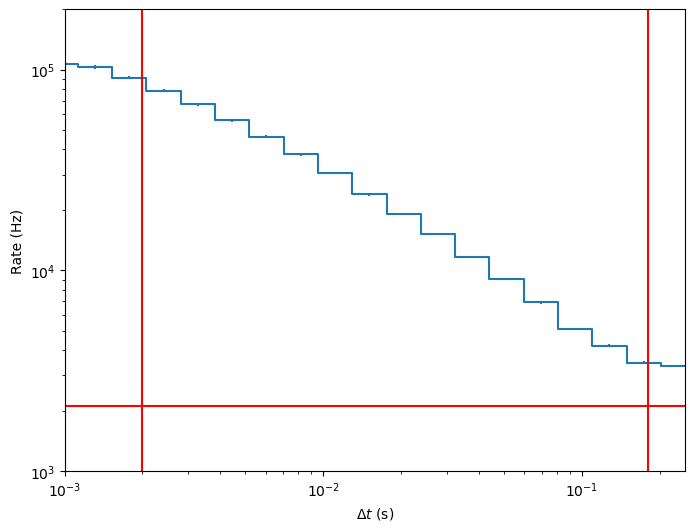

In [15]:
xlim=[1e-3, 0.25]
ylim=[1e3, 2e5]
error_locations = 10**(log_histogram_bins[:-1] + np.diff(log_histogram_bins)/2) #np.diff
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.step(histogram_bins, np.concatenate([weighted_hist, [weighted_hist[-1]]]), where='post') #for bin width
ax.errorbar(error_locations, weighted_hist, yerr=hist_errs*5, fmt='none', label='data (5 sigma error bars)')
#ax.plot(histogram_bins, 2e3*histogram_bins**(-0.72), label='slope = -0.72')
#ax.vlines(x=[max_drift_time_s], ymin=ylim[0], ymax=ylim[1], color='k', linestyle=':')
ax.set(xscale='log', yscale='log', xlim=xlim, ylim=ylim, xlabel='$\Delta t$ (s)', ylabel='Rate (Hz)')
plt.axvline(0.002,color='r')
plt.axvline(0.18,color='r')
plt.axhline(2.1*10**3,color='red')
plt.axhline(10**3*0.9,color='orange')
#ax.legend()
plt.savefig('single-photon train.png')
plt.show()

In [16]:
dfs = pd.DataFrame({
            'lone_hit_channel': lone_hit_channel,
            'lone_hit_dt':lone_hit_dts,
            'primary_x': lone_hit_primary_x,
            'primary_y': lone_hit_primary_y
        })

In [17]:
dfs = dfs[(dfs['lone_hit_dt']*1e-9>0.002)&(dfs['lone_hit_dt']*1e-9<0.18)]


## Lonehits position

In [18]:
PMT_distance_top = 7.95  # cm
PMT_distance_bottom = 8.0  # cm
PMTOuterRingRadius = 3.875  # cm

def get_pmt_positions_top(number):
    array = [i*6 for i in range(7)]
    array[0] = 1
    radius = [i*PMT_distance_top for i in range(7)]
    
    index1 = 0
    iTotal = array[0]
    while number > iTotal:
        index1 += 1
        iTotal += array[index1]

    index2 = number + array[index1] - iTotal
    
    x = radius[index1] * np.cos(index2*np.pi*2 / array[index1])
    y = radius[index1] * np.sin(index2*np.pi*2 / array[index1])
    return x, y

def get_pmt_positions_bottom(number):
    row_distance = np.sqrt(3.)/2. * PMT_distance_bottom
    n_rows = 13;
    n_pmts_top = 127
    
    array = [5, 8, 9, 10, 11, 12, 11, 12, 11, 10, 9, 8, 5]
    PMTsRowOffset = []
    
    for i in range(n_rows):
        PMTsRowOffset.append(-0.5*(array[i]-1)*PMT_distance_bottom)

    index1 = 0
    iTotal = array[0]
    while number > n_pmts_top+iTotal:
        index1 += 1
        iTotal += array[index1]
  
    index2 = number + array[index1] - iTotal -(n_pmts_top+1)
  
    x = PMTsRowOffset[index1] + (index2 * PMT_distance_bottom)
    y = ((0.5*(n_rows-1)-index1) * row_distance);
    return x, y

# rotate tuple over certain angle
def rotate(pos, angle):
    return (pos[0]*np.cos(angle) -pos[1]*np.sin(angle), pos[0]*np.sin(angle) + pos[1]*np.cos(angle))

In [19]:
positions_top = np.array([get_pmt_positions_top(i) for i in range(1, 128)])
# The rotation made is one quarter plus 1.5 PMT (so that pmts 1 and 2 are horizontal and pmts 10 and 11 are vertical)
rotation_angle_top = np.pi/2 + (3/72)*2*np.pi  # Is this the correct rotation?
positions_top = np.array([rotate(pos, rotation_angle_top) for pos in positions_top])

xs_top = positions_top[:,0]
ys_top = positions_top[:,1]

In [20]:
positions_bottom = np.array([get_pmt_positions_bottom(i) for i in range(128, 121+127+1)])
rotation_angle_bottom = np.pi/8  # Is this the correct rotation?
positions_bottom = np.array([rotate(pos, rotation_angle_bottom) for pos in positions_bottom])

xs_bottom = positions_bottom[:,0]
ys_bottom = positions_bottom[:,1]

In [21]:
positions_combined = np.vstack((positions_top, positions_bottom))
channel_to_position = {channel: positions_combined[channel - 1] for channel in range(1, 248)}
# Retrieve positions using lone_hit_channel from lh
lh_positions = np.array([channel_to_position[channel] for channel in dfs['lone_hit_channel']])

# Separate the x and y coordinates
dfs['x'] = lh_positions[:, 0]
dfs['y'] = lh_positions[:, 1]

In [56]:
dfs['dr'] = np.sqrt((dfs['x'] - dfs['primary_x'])**2 + (dfs['y'] - dfs['primary_y'])**2)
dfs['primary_position'] = np.sqrt(dfs['primary_x']**2+dfs['primary_y']**2)
primaries = dfs.drop_duplicates(subset=['primary_position'])
lh_bottom = dfs[dfs['lone_hit_channel']>126]
lh_top = dfs[dfs['lone_hit_channel']<127]

In [34]:
lonehit_channels_bottom = lh_bottom['lone_hit_channel'].unique()
lonehit_channels_top = lh_top['lone_hit_channel'].unique()


In [35]:
def simulate_lonehits(size, PMT_range, lonehit_channels, rate = 5e3+10):
    dt = (1 / rate) * np.ones(size - 1)
    times = np.append([1.0], 1.0 + dt.cumsum()) * 1e9 #time in ns
    times = times.round().astype(np.int64)
    filtered_indices = np.arange(PMT_range[0], PMT_range[1]+1)
    filtered_indices = filtered_indices[np.isin(filtered_indices, lonehit_channels)]
    PMT_indices = np.random.choice(filtered_indices, size=size)
    # Retrieve positions from positions_combined
    x_positions = positions_combined[PMT_indices, 0]
    y_positions = positions_combined[PMT_indices, 1]
    df = pd.DataFrame({
        'x': x_positions,
        'y': y_positions,
        'times': times
    })
    return df

In [105]:
df_lonehit_bottom = simulate_lonehits(10000, (127, 247), lonehit_channels_bottom)
df_lonehit_top = simulate_lonehits(10000, (0, 126), lonehit_channels_top)


In [106]:
primaries_bottom = lh_bottom.drop_duplicates(subset=['primary_position'])
primaries_top = lh_top.drop_duplicates(subset=['primary_position'])

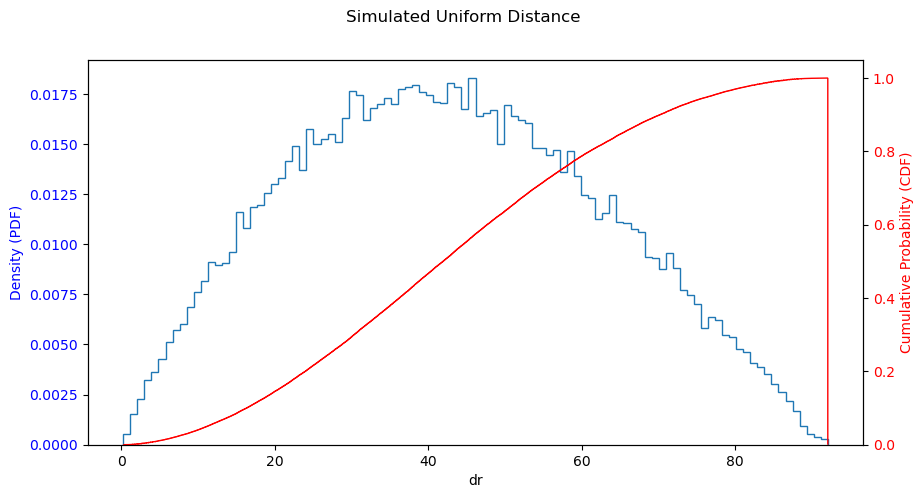

100%|██████████| 1115102/1115102 [00:10<00:00, 106917.74it/s]


In [41]:
len_y = len(df_lonehit_bottom)
len_prim = len(primaries_bottom)
x_prim = primaries_bottom['primary_x'].values
y_prim = primaries_bottom['primary_y'].values
from numba import njit
@njit
def dis(x,y):
    d2 = []
    for i in range(len_prim):
        for j in range(len_y):
            d2.append((x_prim[i] - x[j])**2 + (y_prim[i]-y[j])**2)
    return d2
d2 = dis(df_lonehit_bottom['x'].values,df_lonehit_bottom['y'].values)
d = np.sqrt(d2)

fig, ax1 = plt.subplots(figsize=(10, 5))
# Remove elements where d == 0
d = d[d != 0]
# Plot PDF
ax1.hist(d, bins=100, histtype='step', density=True)
ax1.set_xlabel("dr")
ax1.set_ylabel('Density (PDF)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Plot CDF on the secondary y-axis
ax2 = ax1.twinx()
ax2.hist(d, bins=1000, histtype='step', color='r', cumulative=True, density=True)
ax2.set_ylabel('Cumulative Probability (CDF)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Add title and legend
fig.suptitle('Simulated Uniform Distance')
plt.show()

#pdf
d_hist, d_bins = np.histogram(d, bins=np.linspace(0,max(d),10000))
#cdf
corrdinate_transofmration_histogram = np.cumsum(d_hist)/max(np.cumsum(d_hist))

d_twiddle_observed_bottom = []
for r_old in tqdm(lh_bottom['dr']):
    location = np.argmin(abs(d_bins[1:]-r_old))
    d_twiddle_observed_bottom.append(corrdinate_transofmration_histogram[location])

In [44]:
d_twiddle_simulated_bottom = []
for r_old in tqdm(d):
    location = np.argmin(abs(d_bins[1:]-r_old))
    d_twiddle_simulated_bottom.append(corrdinate_transofmration_histogram[location])

100%|██████████| 769000/769000 [00:07<00:00, 101003.98it/s]


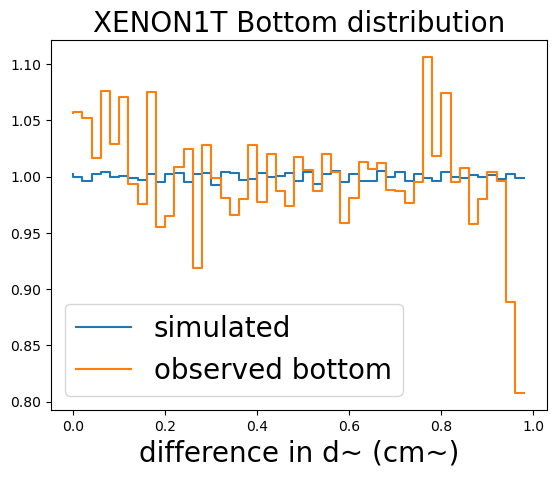

In [45]:
hist_dsb, bins_dsb = np.histogram(d_twiddle_simulated_bottom, bins=50, density=True)
plt.plot(bins_dsb[:-1], hist_dsb, drawstyle='steps', label='simulated')
hist_dob, bins_dob = np.histogram(d_twiddle_observed_bottom, bins=50, density=True)
plt.plot(bins_dob[:-1], hist_dob, drawstyle='steps', label='observed bottom')

plt.xlabel('difference in d~ (cm~)', fontsize=20)
plt.title('XENON1T Bottom distribution', fontsize=20)
plt.legend(fontsize=20)
#plt.yscale('log')
#plt.ylim(0,100)
plt.show()

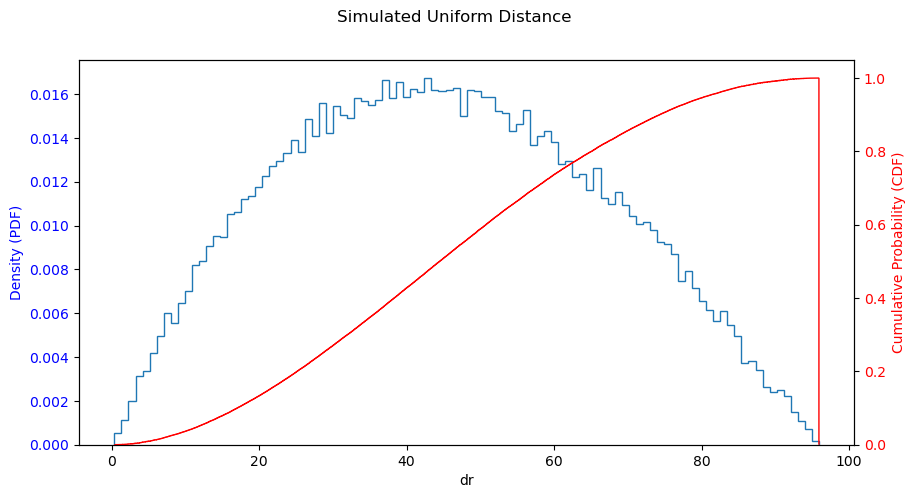

100%|██████████| 769000/769000 [00:07<00:00, 106403.73it/s]


In [48]:
len_y = len(df_lonehit_top)
len_prim = len(primaries_top)
x_prim = primaries_top['primary_x'].values
y_prim = primaries_top['primary_y'].values

d2 = dis(df_lonehit_top['x'].values,df_lonehit_top['y'].values)
d = np.sqrt(d2)

fig, ax1 = plt.subplots(figsize=(10, 5))
# Remove elements where d == 0
d = d[d != 0]
# Plot PDF
ax1.hist(d, bins=100, histtype='step', density=True)
ax1.set_xlabel("dr")
ax1.set_ylabel('Density (PDF)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Plot CDF on the secondary y-axis
ax2 = ax1.twinx()
ax2.hist(d, bins=1000, histtype='step', color='r', cumulative=True, density=True)
ax2.set_ylabel('Cumulative Probability (CDF)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Add title and legend
fig.suptitle('Simulated Uniform Distance')
plt.show()

#pdf
d_hist, d_bins = np.histogram(d, bins=np.linspace(0,max(d),10000))
#cdf
corrdinate_transofmration_histogram = np.cumsum(d_hist)/max(np.cumsum(d_hist))

d_twiddle_observed_top = []
for r_old in tqdm(lh_top['dr']):
    location = np.argmin(abs(d_bins[1:]-r_old))
    d_twiddle_observed_top.append(corrdinate_transofmration_histogram[location])
    
d_twiddle_simulated_top = []
for r_old in tqdm(d):
    location = np.argmin(abs(d_bins[1:]-r_old))
    d_twiddle_simulated_top.append(corrdinate_transofmration_histogram[location])

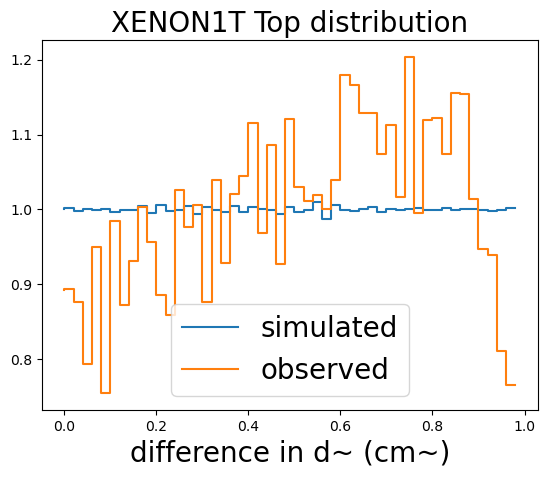

In [49]:
hist_dst, bins_dst = np.histogram(d_twiddle_simulated_top, bins=50, density=True)
plt.plot(bins_dst[:-1], hist_dst, drawstyle='steps', label='simulated')
hist_dot, bins_dot = np.histogram(d_twiddle_observed_top, bins=50, density=True)
plt.plot(bins_dot[:-1], hist_dot, drawstyle='steps', label='observed')

plt.xlabel('difference in d~ (cm~)', fontsize=20)
plt.title('XENON1T Top distribution', fontsize=20)
plt.legend(fontsize=20)
#plt.yscale('log')
#plt.ylim(0,100)
plt.show()


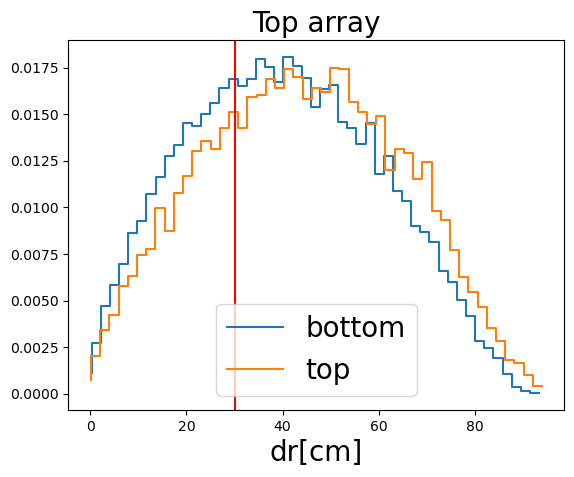

In [50]:
hist_dot, bins_dot = np.histogram(lh_bottom['dr'], bins=50, density=True)
hist_dob, bins_dob = np.histogram(lh_top['dr'] , bins=50, density=True)
plt.plot(bins_dot[:-1], hist_dot, drawstyle='steps', label='bottom')
plt.plot(bins_dob[:-1], hist_dob, drawstyle='steps', label='top')
plt.xlabel('dr[cm]', fontsize=20)
plt.title('Top array', fontsize=20)
plt.legend(fontsize=20)
plt.axvline(30,color='r')
#plt.yscale('log')
#plt.ylim(0,100)
plt.show()

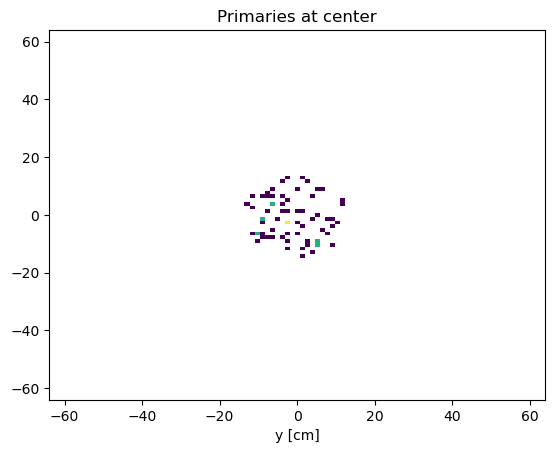

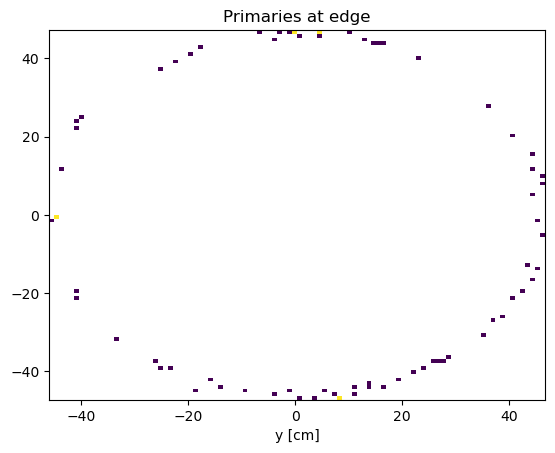

In [78]:
primaries_center = primaries[primaries['primary_position']<14]
primaries_edge = primaries[primaries['primary_position']>45]
plt.hist2d(primaries_center['primary_x'],primaries_center['primary_y'],bins=[np.linspace(-64,64,100),np.linspace(-64,64,100)],norm=colors.LogNorm())
plt.xlim(-64,64)
plt.ylim(-64,64)
plt.xlabel('x [cm]')
plt.xlabel('y [cm]')
plt.title('Primaries at center')
plt.show()
plt.hist2d(primaries_edge['primary_x'],primaries_edge['primary_y'],bins=100,norm=colors.LogNorm())
plt.xlabel('x [cm]')
plt.xlabel('y [cm]')
plt.title('Primaries at edge')
plt.show()

In [91]:
result_top_primaries_at_center = lh_top[lh_top['primary_position']<14]
result_bottom_primaries_at_center = lh_bottom[lh_bottom['primary_position']<14]
result_top_primaries_at_edge = lh_top[lh_top['primary_position']>45]
result_bottom_primaries_at_edge = lh_bottom[lh_bottom['primary_position']>45]


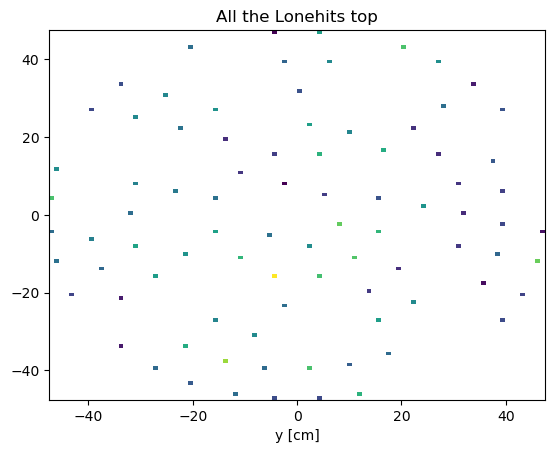

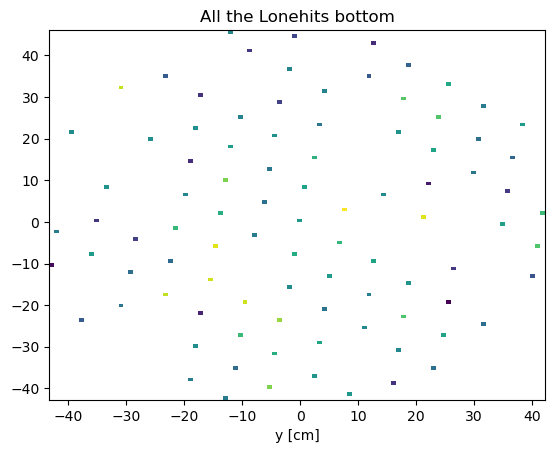

In [59]:
plt.hist2d(lh_top['x'],lh_top['y'],bins=100,norm=colors.LogNorm())
plt.xlabel('x [cm]')
plt.xlabel('y [cm]')
plt.title('All the Lonehits top')
plt.show()
plt.hist2d(lh_bottom['x'],lh_bottom['y'],bins=100,norm=colors.LogNorm())
plt.xlabel('x [cm]')
plt.xlabel('y [cm]')
plt.title('All the Lonehits bottom')
plt.show()

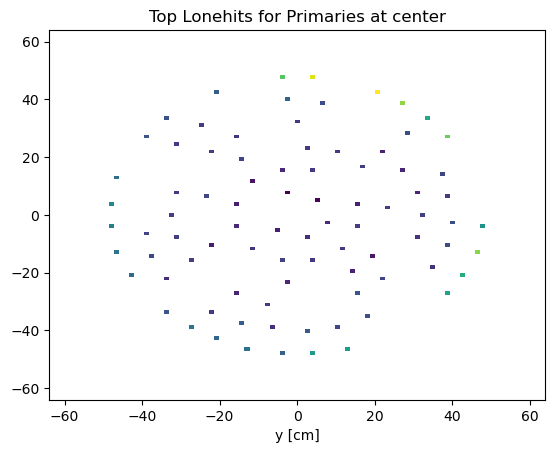

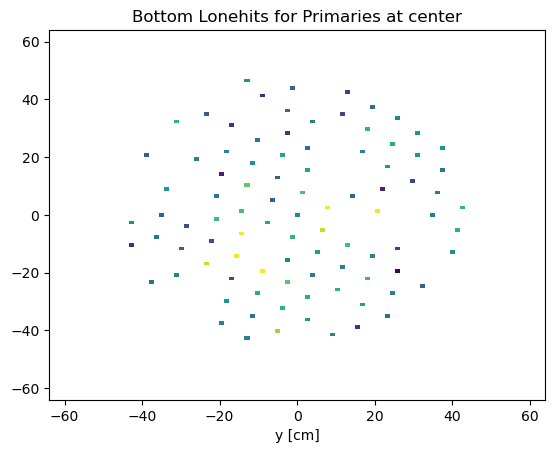

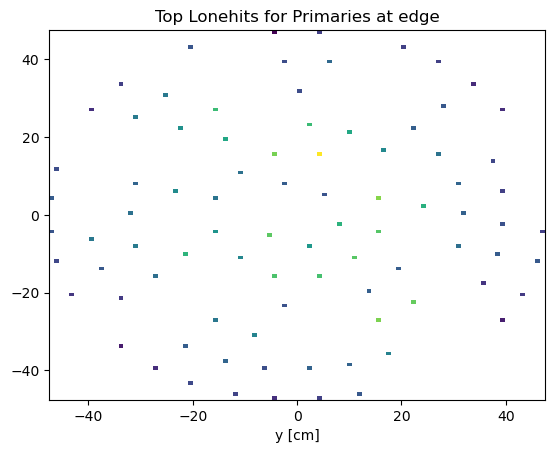

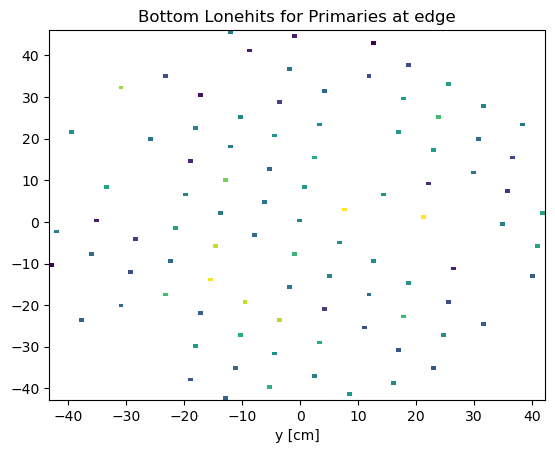

In [81]:
plt.hist2d(result_top_primaries_at_center['x'],result_top_primaries_at_center['y'],bins=[np.linspace(-64,64,100),np.linspace(-64,64,100)],norm=colors.LogNorm())
plt.xlim(-64,64)
plt.ylim(-64,64)
plt.xlabel('x [cm]')
plt.xlabel('y [cm]')
plt.title('Top Lonehits for Primaries at center')
plt.show()
plt.hist2d(result_bottom_primaries_at_center['x'],result_bottom_primaries_at_center['y'],bins=[np.linspace(-64,64,100),np.linspace(-64,64,100)],norm=colors.LogNorm())
plt.xlim(-64,64)
plt.ylim(-64,64)
plt.xlabel('x [cm]')
plt.xlabel('y [cm]')
plt.title('Bottom Lonehits for Primaries at center')
plt.show()
plt.hist2d(result_top_primaries_at_edge['x'],result_top_primaries_at_edge['y'],bins=100,norm=colors.LogNorm())
plt.xlabel('x [cm]')
plt.xlabel('y [cm]')
plt.title('Top Lonehits for Primaries at edge')
plt.show()
plt.hist2d(result_bottom_primaries_at_edge['x'],result_bottom_primaries_at_edge['y'],bins=100,norm=colors.LogNorm())
plt.xlabel('x [cm]')
plt.xlabel('y [cm]')
plt.title('Bottom Lonehits for Primaries at edge')
plt.show()

In [87]:
lh_top['dr_square'] = (lh_top['x']-lh_top['primary_x'])**2+(lh_top['y']-lh_top['primary_y'])**2
lh_bottom['dr_square'] = (lh_bottom['x']-lh_bottom['primary_x'])**2+(lh_bottom['y']-lh_bottom['primary_y'])**2


/tmp/ipykernel_545642/2433962946.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lh_top['dr_square'] = (lh_top['x']-lh_top['primary_x'])**2+(lh_top['y']-lh_top['primary_y'])**2
/tmp/ipykernel_545642/2433962946.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lh_bottom['dr_square'] = (lh_bottom['x']-lh_bottom['primary_x'])**2+(lh_bottom['y']-lh_bottom['primary_y'])**2


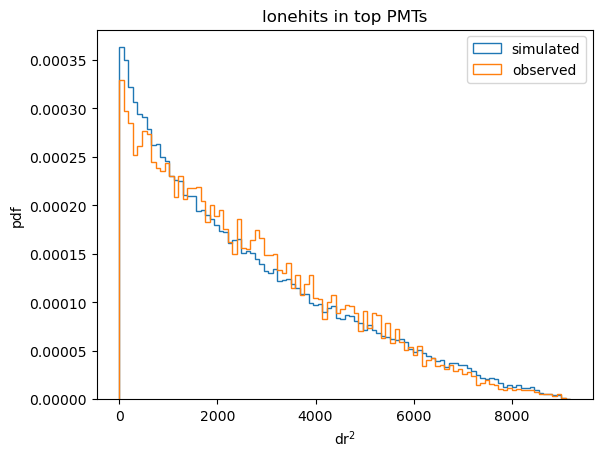

In [107]:
len_y = len(df_lonehit_top)
len_prim = len(primaries_top)
x_prim = primaries_top['primary_x'].values
y_prim = primaries_top['primary_y'].values

d2 = dis(df_lonehit_top['x'].values,df_lonehit_top['y'].values)
plt.hist(d2,bins=100,density=True,histtype='step',label='simulated')
plt.hist(lh_top['dr_square'],bins=100,density=True,histtype='step',label='observed')
plt.xlabel(r"dr$^2$")
plt.ylabel('pdf')
plt.title('lonehits in top PMTs')
plt.legend()
plt.savefig('Simulated vs Observed distance: lonehits in top PMTs.svg')
plt.show()

In [109]:
def dis(x,y):
    d2 = []
    for i in tqdm(range(len_prim)):
        for j in range(len_y):
            d2.append((x_prim[i] - x[j])**2 + (y_prim[i]-y[j])**2)
    return d2

100%|██████████| 69/69 [00:00<00:00, 195.08it/s]


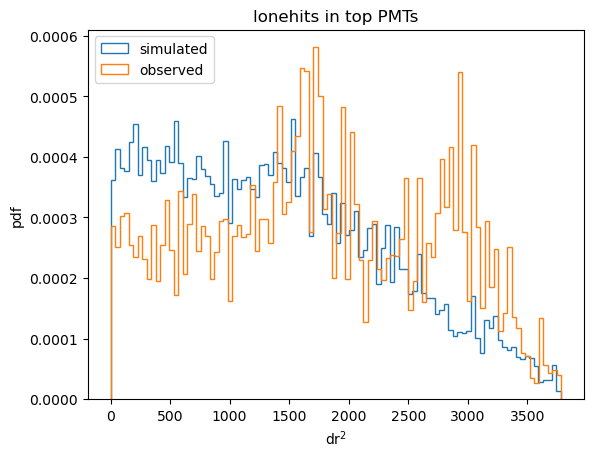

In [111]:
len_y = len(df_lonehit_top)
len_prim = len(primaries_center)
x_prim = primaries_center['primary_x'].values
y_prim = primaries_center['primary_y'].values

d2 = dis(df_lonehit_top['x'].values,df_lonehit_top['y'].values)
plt.hist(d2,bins=100,density=True,histtype='step',label='simulated')
plt.hist(result_top_primaries_at_center['dr_square'],bins=100,density=True,histtype='step',label='observed')
plt.xlabel(r"dr$^2$")
plt.ylabel('pdf')
plt.title('lonehits in top PMTs')
plt.legend()
plt.savefig('Simulated vs Observed distance: lonehits in top PMTs center primaries.svg')
plt.show()


100%|██████████| 69/69 [00:00<00:00, 184.67it/s]


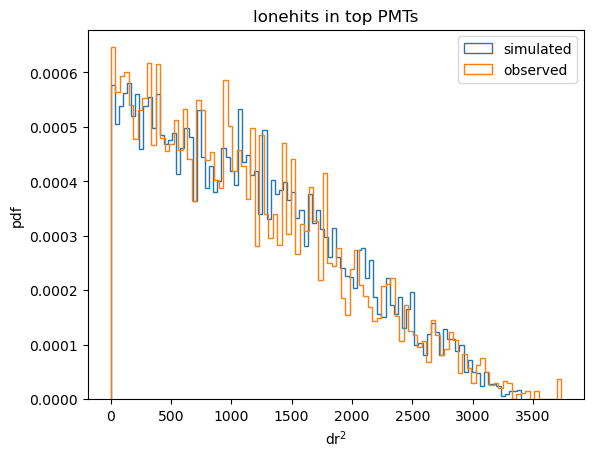

In [114]:
len_y = len(df_lonehit_bottom)
len_prim = len(primaries_center)
x_prim = primaries_center['primary_x'].values
y_prim = primaries_center['primary_y'].values

d2 = dis(df_lonehit_bottom['x'].values,df_lonehit_bottom['y'].values)
plt.hist(d2,bins=100,density=True,histtype='step',label='simulated')
plt.hist(result_bottom_primaries_at_center['dr_square'],bins=100,density=True,histtype='step',label='observed')
plt.xlabel(r"dr$^2$")
plt.ylabel('pdf')
plt.title('lonehits in top PMTs')
plt.legend()
plt.savefig('Simulated vs Observed distance: lonehits in top PMTs.svg')
plt.show()

100%|██████████| 74/74 [00:00<00:00, 192.96it/s]


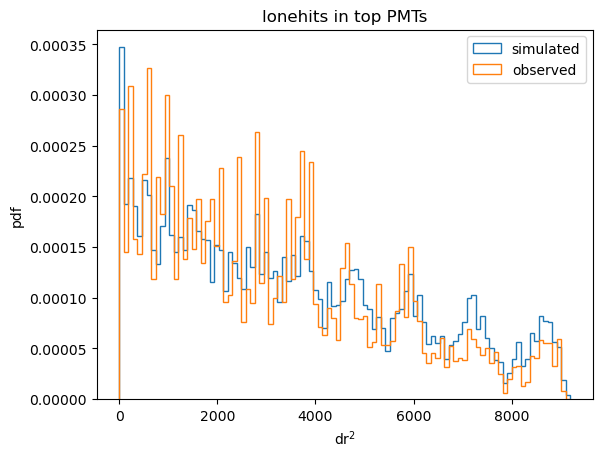

In [113]:
len_y = len(df_lonehit_top)
len_prim = len(primaries_edge)
x_prim = primaries_edge['primary_x'].values
y_prim = primaries_edge['primary_y'].values

d2 = dis(df_lonehit_top['x'].values,df_lonehit_top['y'].values)
plt.hist(d2,bins=100,density=True,histtype='step',label='simulated')
plt.hist(result_top_primaries_at_edge['dr_square'],bins=100,density=True,histtype='step',label='observed')
plt.xlabel(r"dr$^2$")
plt.ylabel('pdf')
plt.title('lonehits in top PMTs')
plt.legend()
plt.savefig('Simulated vs Observed distance: lonehits in top PMTs center primaries.svg')
plt.show()


100%|██████████| 74/74 [00:00<00:00, 187.25it/s]


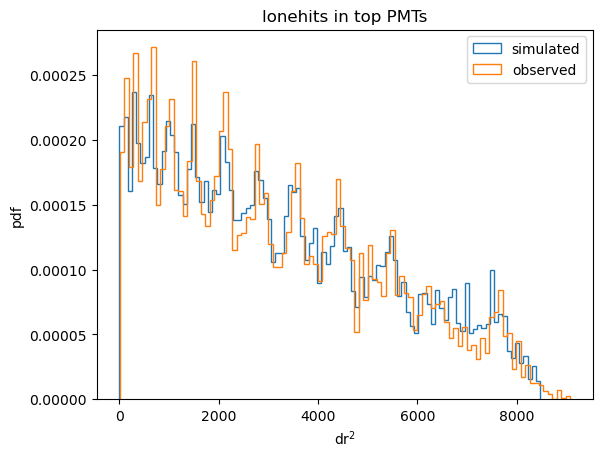

In [118]:
len_y = len(df_lonehit_bottom)
len_prim = len(primaries_edge)
x_prim = primaries_edge['primary_x'].values
y_prim = primaries_edge['primary_y'].values

d2 = dis(df_lonehit_bottom['x'].values,df_lonehit_bottom['y'].values)
plt.hist(d2,bins=100,density=True,histtype='step',label='simulated')
plt.hist(result_bottom_primaries_at_edge['dr_square'],bins=100,density=True,histtype='step',label='observed')
plt.xlabel(r"dr$^2$")
plt.ylabel('pdf')
plt.title('lonehits in top PMTs')
plt.legend()
plt.savefig('Simulated vs Observed distance: lonehits in top PMTs.svg')
plt.show()

100%|██████████| 69/69 [00:00<00:00, 194.01it/s]


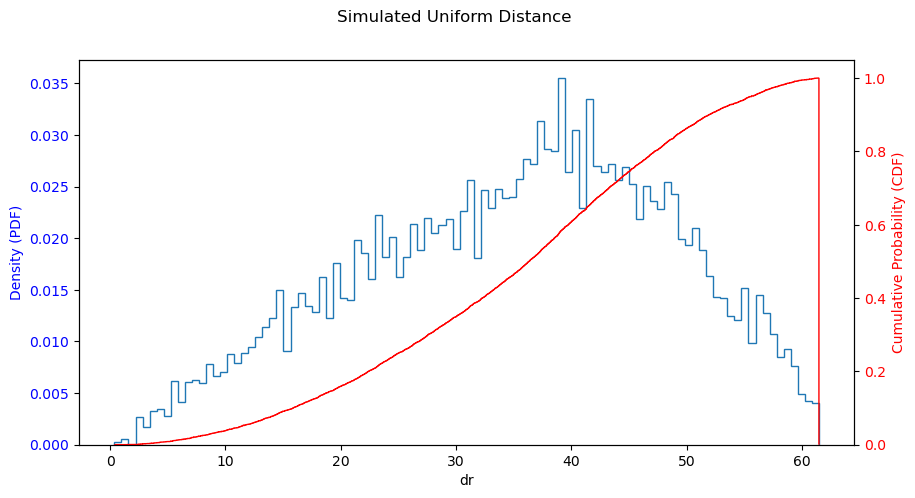

100%|██████████| 690000/690000 [00:06<00:00, 100462.13it/s]


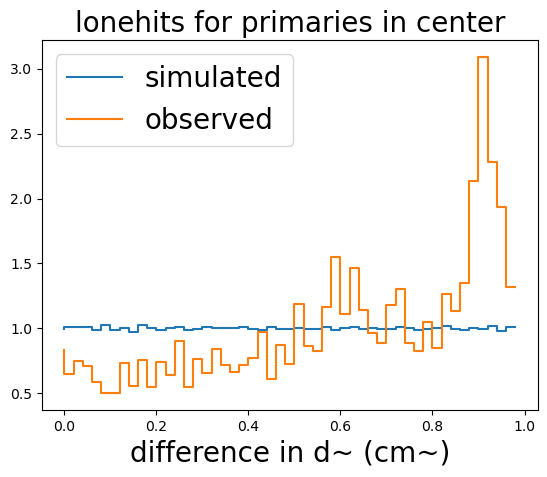

In [120]:
len_y = len(df_lonehit_top)
len_prim = len(primaries_center)
x_prim = primaries_center['primary_x'].values
y_prim = primaries_center['primary_y'].values

d2 = dis(df_lonehit_top['x'].values,df_lonehit_top['y'].values)
d = np.sqrt(d2)

fig, ax1 = plt.subplots(figsize=(10, 5))
# Remove elements where d == 0
d = d[d != 0]
# Plot PDF
ax1.hist(d, bins=100, histtype='step', density=True)
ax1.set_xlabel("dr")
ax1.set_ylabel('Density (PDF)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Plot CDF on the secondary y-axis
ax2 = ax1.twinx()
ax2.hist(d, bins=1000, histtype='step', color='r', cumulative=True, density=True)
ax2.set_ylabel('Cumulative Probability (CDF)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Add title and legend
fig.suptitle('Simulated Uniform Distance')
plt.show()

#pdf
d_hist, d_bins = np.histogram(d, bins=np.linspace(0,max(d),10000))
#cdf
corrdinate_transofmration_histogram = np.cumsum(d_hist)/max(np.cumsum(d_hist))

d_twiddle_observed_top = []
for r_old in tqdm(result_top_primaries_at_center['dr']):
    location = np.argmin(abs(d_bins[1:]-r_old))
    d_twiddle_observed_top.append(corrdinate_transofmration_histogram[location])
    
d_twiddle_simulated_top = []
for r_old in tqdm(d):
    location = np.argmin(abs(d_bins[1:]-r_old))
    d_twiddle_simulated_top.append(corrdinate_transofmration_histogram[location])
    
hist_dst, bins_dst = np.histogram(d_twiddle_simulated_top, bins=50, density=True)
plt.plot(bins_dst[:-1], hist_dst, drawstyle='steps', label='simulated')
hist_dot, bins_dot = np.histogram(d_twiddle_observed_top, bins=50, density=True)
plt.plot(bins_dot[:-1], hist_dot, drawstyle='steps', label='observed')

plt.xlabel('difference in d~ (cm~)', fontsize=20)
plt.title('lonehits for primaries in center', fontsize=20)
plt.legend(fontsize=20)
#plt.yscale('log')
#plt.ylim(0,100)
plt.show()


100%|██████████| 125/125 [00:00<00:00, 183.74it/s]


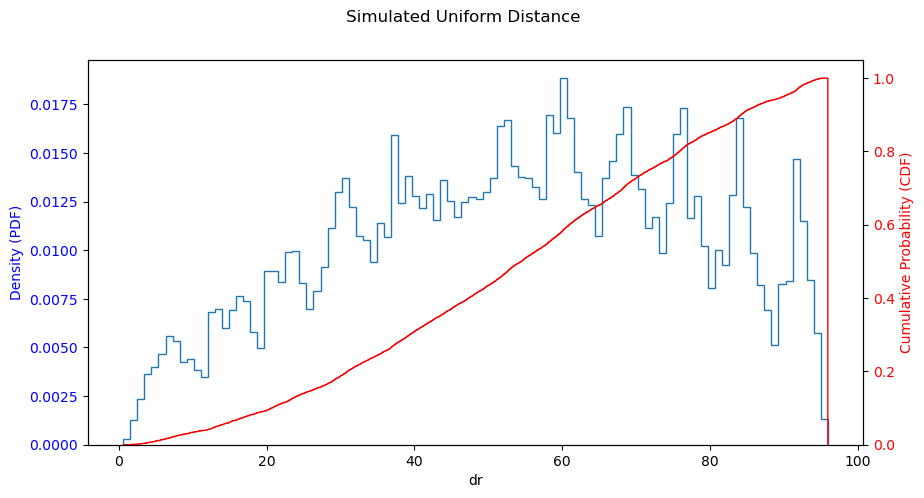

100%|██████████| 1250000/1250000 [00:11<00:00, 107048.05it/s]


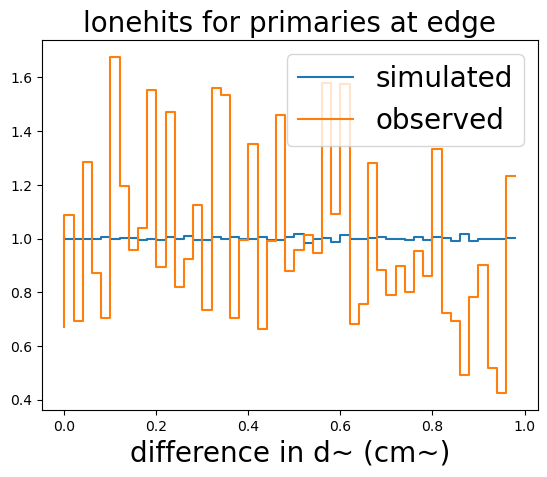

In [123]:
primaries_edge = primaries[primaries['primary_position']>44]

len_y = len(df_lonehit_top)
len_prim = len(primaries_edge)
x_prim = primaries_edge['primary_x'].values
y_prim = primaries_edge['primary_y'].values

d2 = dis(df_lonehit_top['x'].values,df_lonehit_top['y'].values)
d = np.sqrt(d2)

fig, ax1 = plt.subplots(figsize=(10, 5))
# Remove elements where d == 0
d = d[d != 0]
# Plot PDF
ax1.hist(d, bins=100, histtype='step', density=True)
ax1.set_xlabel("dr")
ax1.set_ylabel('Density (PDF)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Plot CDF on the secondary y-axis
ax2 = ax1.twinx()
ax2.hist(d, bins=1000, histtype='step', color='r', cumulative=True, density=True)
ax2.set_ylabel('Cumulative Probability (CDF)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Add title and legend
fig.suptitle('Simulated Uniform Distance')
plt.show()

#pdf
d_hist, d_bins = np.histogram(d, bins=np.linspace(0,max(d),10000))
#cdf
corrdinate_transofmration_histogram = np.cumsum(d_hist)/max(np.cumsum(d_hist))

d_twiddle_observed_top = []
for r_old in tqdm(result_top_primaries_at_edge['dr']):
    location = np.argmin(abs(d_bins[1:]-r_old))
    d_twiddle_observed_top.append(corrdinate_transofmration_histogram[location])
    
d_twiddle_simulated_top = []
for r_old in tqdm(d):
    location = np.argmin(abs(d_bins[1:]-r_old))
    d_twiddle_simulated_top.append(corrdinate_transofmration_histogram[location])
    
hist_dst, bins_dst = np.histogram(d_twiddle_simulated_top, bins=50, density=True)
plt.plot(bins_dst[:-1], hist_dst, drawstyle='steps', label='simulated')
hist_dot, bins_dot = np.histogram(d_twiddle_observed_top, bins=50, density=True)
plt.plot(bins_dot[:-1], hist_dot, drawstyle='steps', label='observed')

plt.xlabel('difference in d~ (cm~)', fontsize=20)
plt.title('lonehits for primaries at edge', fontsize=20)
plt.legend(fontsize=20)
#plt.yscale('log')
#plt.ylim(0,100)
plt.show()
